# 目录
1. [数据读取与预处理](#1.数据读取与预处理) 
2. [经济指标探索性分析](#2.经济指标探索性分析)<br>
&emsp;&emsp;2.1 [货币兑美元的汇率变化情况](#2.1)<br> 
&emsp;&emsp;2.2 [通货膨胀率变化情况](#2.2)<br>
&emsp;&emsp;2.3 [其他危机分布情况](#2.3)<br>
&emsp;&emsp;2.3 [特征间的相关性](#2.3)<br>
3. [构建银行危机预测模型](#3.构建银行危机预测模型)<br>
&emsp;&emsp;3.1 [特征编码](#3.1)<br> 
&emsp;&emsp;3.2 [数据集划分与分层采样](#3.2)<br>
&emsp;&emsp;3.3 [SMOTE合成采样](#3.3)<br>
&emsp;&emsp;3.4 [建立随机森林预测模型](#3.4)<br>
&emsp;&emsp;3.5 [模型评估](#3.5)<br>
4. [总结](#4.总结)

数据共计1059条，各数据字段含义如下表所示：

|字段|含义
|:-|:-
|case |国家编号，代表特定国家的数字
|cc3 |国家代码，三个字母的国家/地区代码
|country |国家名称
|year |观测年份
|systemic_crisis|系统性危机，“ 0”表示当年未发生系统性危机，“ 1”表示当年有发生系统性危机。
|exch_usd|该国货币兑美元的汇率
|domestic_debt_in_default|国内债务违约，“0”表示当年未发生国内债务违约，“1”表示当年有发生国内债务违约
|sovereign_external_debt_default|主权外债违约，“0”表示当年未发生主权外债违约，“1”表示当年有发生主权外债违约
|gdp_weighted_default|违约债务总额与GDP之比
|inflation_annual_cpi|年度CPI通货膨胀率
|independence|独立性，“ 0”表示“无独立性”，“ 1”表示“独立性”
|currency_crises|货币危机，“ 0”表示当年未发生“货币危机”，“ 1”表示当年有发生“货币危机”	
|inflation_crises|通胀危机，“ 0”表示当年未发生“通胀危机”，“ 1”表示当年有发生“通胀危机”
|banking_crisis|银行业危机，“ no_crisis”表示当年没有发生银行业危机，而“ crisis”表示当年有发生银行业危机。

# 1.数据读取与预处理

In [41]:
# 导入相应模块
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname = "./input/SimHei.ttf", size=14)

import seaborn as sns
import random

# 设置绘图风格
%matplotlib inline
sns.set(style='whitegrid')

# 忽略所有警告
import warnings
warnings.filterwarnings('ignore')

# 读取数据
data = pd.read_csv('./input/african_crises.csv')
data.sample(5)


case  cc3                   country  year  systemic_crisis  \
489     35  KEN                     Kenya  1999                1   
197     10  CAF  Central African Republic  1992                1   
979     70  ZWE                  Zimbabwe  1934                0   
798     56  ZAF              South Africa  1990                0   
1002    70  ZWE                  Zimbabwe  1957                0   

          exch_usd  domestic_debt_in_default  sovereign_external_debt_default  \
489   7.293060e+01                         0                                0   
197   2.753248e+02                         0                                1   
979   4.040000e-27                         0                                0   
798   2.562526e+00                         0                                0   
1002  7.100000e-27                         0                                0   

      gdp_weighted_default  inflation_annual_cpi  independence  \
489                    0.0              5.753000             1   
197                    0.0             -0.757000             1   
979                    0.0             -1.010101             0   
798                    0.0             14.286000             1   
1002                   0.0              2.970297             0   

      currency_crises  inflation_crises banking_crisis  
489                 1                 0      no_crisis  
197                 0                 0         crisis  
979                 0                 0      no_crisis  
798                 0                 0      no_crisis  
1002                0                 0      no_crisis

首先我们查看一共有哪些国家。

In [42]:
unique_countries = data.country.unique()
unique_countries

array(['Algeria', 'Angola', 'Central African Republic', 'Ivory Coast',
       'Egypt', 'Kenya', 'Mauritius', 'Morocco', 'Nigeria',
       'South Africa', 'Tunisia', 'Zambia', 'Zimbabwe'], dtype=object)

可以看到数据中一共包含13个非洲国家，按顺序分别为阿尔及利亚，安哥拉，中非共和国，象牙海岸，埃及，肯尼亚，毛里求斯，摩洛哥， 尼日利亚，南非，突尼斯，赞比亚和津巴布韦。接下来我们使用描述性统计函数查看数据的基本情况以及数据中是否存在缺失和异常。

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 14 columns):
case                               1059 non-null int64
cc3                                1059 non-null object
country                            1059 non-null object
year                               1059 non-null int64
systemic_crisis                    1059 non-null int64
exch_usd                           1059 non-null float64
domestic_debt_in_default           1059 non-null int64
sovereign_external_debt_default    1059 non-null int64
gdp_weighted_default               1059 non-null float64
inflation_annual_cpi               1059 non-null float64
independence                       1059 non-null int64
currency_crises                    1059 non-null int64
inflation_crises                   1059 non-null int64
banking_crisis                     1059 non-null object
dtypes: float64(3), int64(8), object(3)
memory usage: 115.9+ KB


可以看到除了国家代码`cc3`、国家名称`country`和银行危机`banking_crisis`这三个字段为字符型之外，其余均为数值类型，且数据中不存在缺失值。

In [44]:
data.describe(include = 'all')

case   cc3 country         year  systemic_crisis     exch_usd  \
count   1059.000000  1059    1059  1059.000000      1059.000000  1059.000000   
unique          NaN    13      13          NaN              NaN          NaN   
top             NaN   EGY   Egypt          NaN              NaN          NaN   
freq            NaN   155     155          NaN              NaN          NaN   
mean      35.613787   NaN     NaN  1967.767705         0.077432    43.140831   
std       23.692402   NaN     NaN    33.530632         0.267401   111.475380   
min        1.000000   NaN     NaN  1860.000000         0.000000     0.000000   
25%       15.000000   NaN     NaN  1951.000000         0.000000     0.195350   
50%       38.000000   NaN     NaN  1973.000000         0.000000     0.868400   
75%       56.000000   NaN     NaN  1994.000000         0.000000     8.462750   
max       70.000000   NaN     NaN  2014.000000         1.000000   744.306139   

        domestic_debt_in_default  sovereign_external_debt_default  \
count                1059.000000                      1059.000000   
unique                       NaN                              NaN   
top                          NaN                              NaN   
freq                         NaN                              NaN   
mean                    0.039660                         0.152975   
std                     0.195251                         0.360133   
min                     0.000000                         0.000000   
25%                     0.000000                         0.000000   
50%                     0.000000                         0.000000   
75%                     0.000000                         0.000000   
max                     1.000000                         1.000000   

        gdp_weighted_default  inflation_annual_cpi  independence  \
count            1059.000000          1.059000e+03   1059.000000   
unique                   NaN                   NaN           NaN   
top                      NaN                   NaN           NaN   
freq                     NaN                   NaN           NaN   
mean                0.006402          2.084889e+04      0.776204   
std                 0.043572          6.757274e+05      0.416984   
min                 0.000000         -2.850214e+01      0.000000   
25%                 0.000000          2.086162e+00      1.000000   
50%                 0.000000          5.762330e+00      1.000000   
75%                 0.000000          1.164405e+01      1.000000   
max                 0.400000          2.198970e+07      1.000000   

        currency_crises  inflation_crises banking_crisis  
count       1059.000000       1059.000000           1059  
unique              NaN               NaN              2  
top                 NaN               NaN      no_crisis  
freq                NaN               NaN            965  
mean           0.132200          0.129367            NaN  
std            0.349847          0.335765            NaN  
min            0.000000          0.000000            NaN  
25%            0.000000          0.000000            NaN  
50%            0.000000          0.000000            NaN  
75%            0.000000          0.000000            NaN  
max            2.000000          1.000000            NaN

通过观察统计性指标，我们看到年份`year`的最大最小值分别为2014年和1860年，埃及的统计记录最多，有155条数据。同时我们也发现一个异常，货币危机`currency_crises`的取值范围为0、1，但数据中出现了取值2，我们需要单独进行处理，且其余指标无明显异常。

In [45]:
data[data['currency_crises'] == 2]

case  cc3       country  year  systemic_crisis  exch_usd  \
142     2  AGO        Angola  1995                0  0.005692   
146     2  AGO        Angola  1999                0  5.579920   
775    56  ZAF  South Africa  1967                0  0.709300   
840    63  TUN       Tunisia  1958                0  0.419700   

     domestic_debt_in_default  sovereign_external_debt_default  \
142                         1                                1   
146                         1                                1   
775                         0                                0   
840                         0                                1   

     gdp_weighted_default  inflation_annual_cpi  independence  \
142                  0.00           2672.230000             1   
146                  0.00            248.248000             1   
775                  0.00              2.151508             1   
840                  0.06              5.216941             1   

     currency_crises  inflation_crises banking_crisis  
142                2                 1         crisis  
146                2                 1      no_crisis  
775                2                 0      no_crisis  
840                2                 0      no_crisis

可以看到存在异常的数据只有4条，我们直接进行删除。

In [46]:
data = data[data['currency_crises'] != 2]
data.shape

(1055, 14)

# 2.经济指标探索性分析

在二战之后，当今世界的格局初步形成，在60年代之后，非洲掀起了摆脱殖民主义的独立浪潮。由于几百年的历史原因，非洲大陆是地球上发展最落后的地区，多数国家经济政治发展较为落后，人口素质较低，经济体系较为脆弱，各种危机时常发生。接下来我们通过该数据集分析一下在独立前后的各个国家的经济发展以及面临经济危机的情况。首先我们绘制13个国家的货币兑美元的汇率变化情况的折线图。

## <a id=2.1></a> 2.1 货币兑美元的汇率变化情况

In [47]:
plt.figure(figsize=(12,20))


for i in range(13):
    
    plt.subplot(7,2,i+1)
    country = unique_countries[i]
    
    # 随机生成一种颜色 random.choice():从一个序列中随机的抽取一个元素，抽取6次组成6位代表随机颜色
    col="#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    
    sns.lineplot(data[data.country == country]['year'],data[data.country == country]['exch_usd'],label = country,color = col)
    
    # np.logical_and()逻辑与 两个条件均成立时返回True
    plt.plot([np.min(data[np.logical_and(data.country == country,data.independence == 1)]['year']),
              np.min(data[np.logical_and(data.country == country,data.independence == 1)]['year'])],
             [0,np.max(data[data.country == country]['exch_usd'])],color = 'black',linestyle = 'dotted',alpha = 0.8)
    

    plt.title(country)
    
plt.tight_layout()
plt.show()


可以看到，大部分国家在在独立前和独立之后的短期阶段并没有自己的货币体系，仍沿用殖民统治国家的货币，如法币或英镑。安哥拉(Angola)、津巴布韦(Zimbabwe)、赞比亚(Zambia)、尼日利亚(Nigeria)等过汇率长期维持在0，在21世纪左右开始有了本国货币。另外还能发现大部分非洲国家随着时间的发展，以美元为基准，货币呈现逐步贬值的状态。

## <a id=2.2></a> 2.2 通货膨胀率变化情况

通货膨胀率也称为物价变化率，是货币超发部分与实际需要的货币量之比，用以反映通货膨胀、货币贬值的程度。通过价格指数的增长率来计算通货膨胀率，在本数据中采用的是消费者价格指数（CPI）来进行表示的。

按照价格上升的速度加以区分：
+ 温和的通货膨胀（每年物价上升比例在1%~6%之内）
+ 严重的通货膨胀（每年物价上升比例在6%~9%）
+ 飞奔的通货膨胀（每年物价上升比例在10%~50%以下）
+ 恶性的通货膨胀（每年物价上升比例在50%以上）

接下来我们分析一下各国的通货膨胀率变化情况。

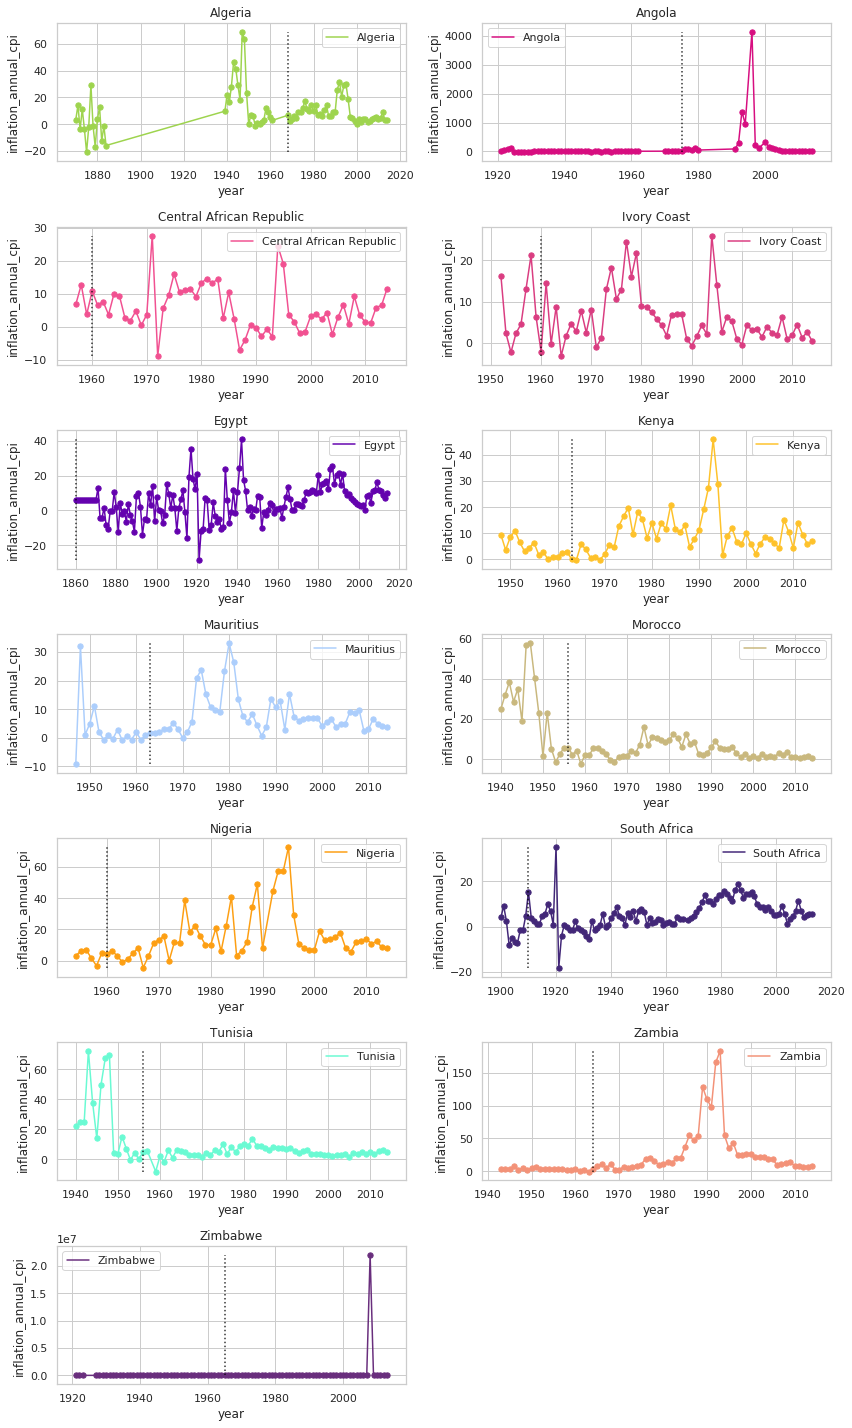

In [48]:
plt.figure(figsize=(12,20))


for i in range(13):
    
    plt.subplot(7,2,i+1)
    country = unique_countries[i]
    
    # 随机生成一种颜色
    col="#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    
    sns.lineplot(data[data.country == country]['year'],data[data.country == country]['inflation_annual_cpi'],label = country,color = col)
    
    plt.scatter(data[data.country == country]['year'],data[data.country == country]['inflation_annual_cpi'],color = col,s = 28)
    
    plt.plot([np.min(data[np.logical_and(data.country == country,data.independence==1)]['year']),
              np.min(data[np.logical_and(data.country == country,data.independence==1)]['year'])],
             [np.min(data[data.country == country]['inflation_annual_cpi']),np.max(data[data.country == country]['inflation_annual_cpi'])],
             color = 'black',linestyle = 'dotted',alpha = 0.8)

    plt.title(country)
    
plt.tight_layout()
plt.show()

可以看到这些非洲国家中大部分均出现了不同程度的通货膨胀，如南非(South Africa)在1970-1990之间由于种族隔离政策不断被西方经济体制裁导致经济受到大幅度影响；安哥拉(Angola)在20世纪90年代发生多次内战，战争导致通货膨胀率疯狂飙升，在最高一年达到4000以上。也有部分国家经济较为稳定，如突尼斯(Tunisa)独立后，通货膨胀率经过短暂上升又逐渐下降至较低水平并保持稳定。

## <a id=2.3></a>  2.3 其他危机分布情况

接下来我们分析一下数据的其他字段：不同国家的系统性危机`systemic_crisis`、国内债务违约`domestic_debt_in_default`、主权外债违约`sovereign_external_debt_default`、货币危机`currency_crises`、通胀危机`inflation_crises`、银行危机`banking_crisis`等的分布规律。

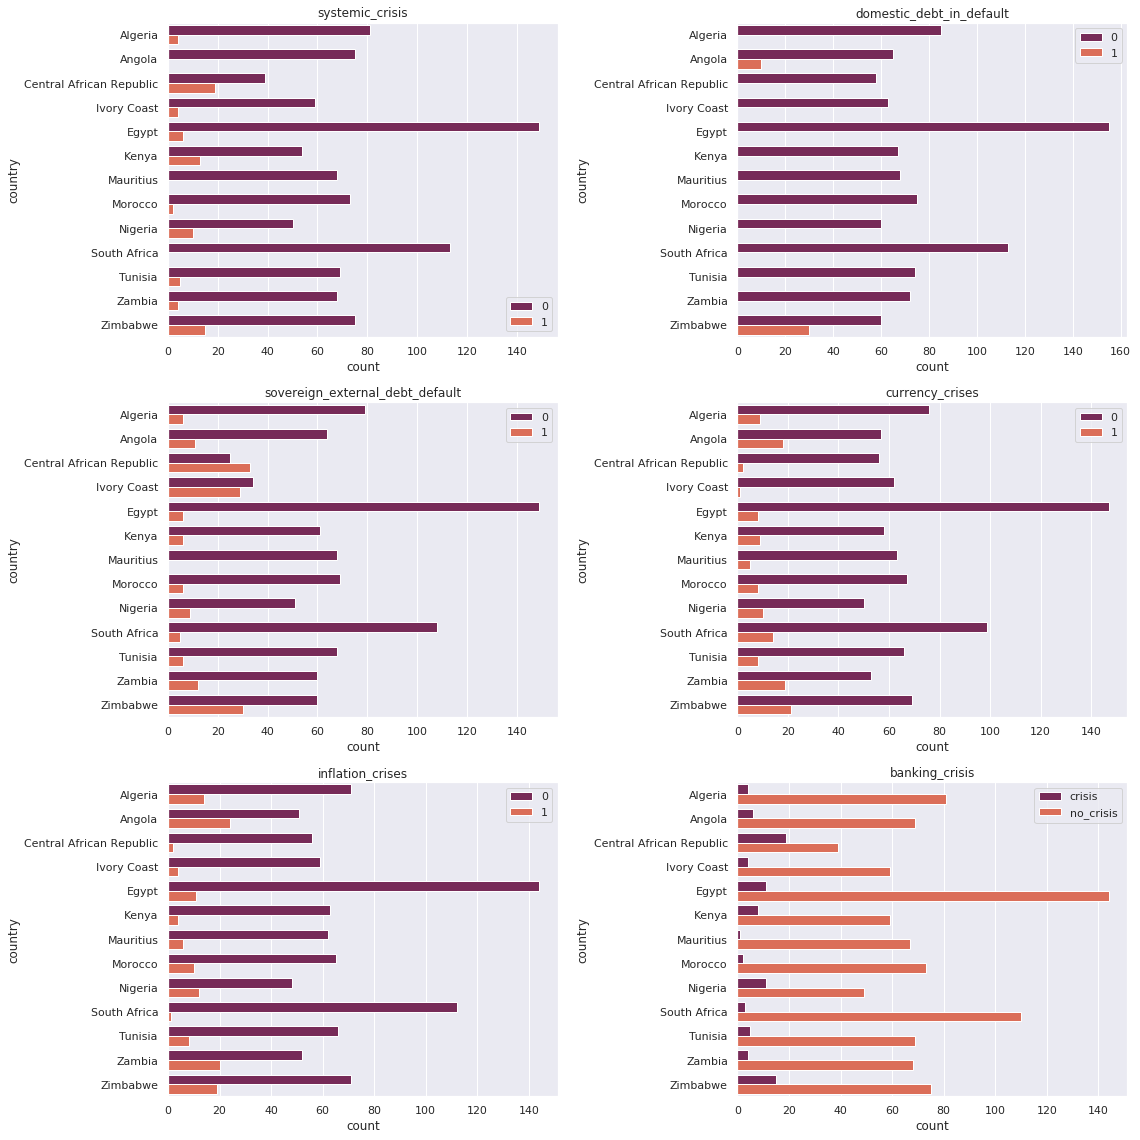

In [49]:
sns.set(style='darkgrid')
columns = ['systemic_crisis','domestic_debt_in_default','sovereign_external_debt_default','currency_crises','inflation_crises','banking_crisis']

plt.figure(figsize=(16,16))

for i in range(6):
    plt.subplot('32'+str(i+1))
    sns.countplot(y = data.country,hue = data[columns[i]],palette = 'rocket')
    plt.legend(loc = 0)
    plt.title(columns[i])
    
plt.tight_layout()
plt.show()


+ 主权外债违约`sovereign_external_debt_default`是指一国政府无法按时对其向外担保借来的债务还本付息的情况，观察上图可以发现中非共和国(Central African Republic)、津巴布韦(Zimbabwe)和象牙海岸(Ivory Coast)出现大量的主权外债违约，这导致主权信用评级极低。

+ 同时我们还能发现，除了安哥拉(Angola)、津巴布韦(Zimbabwe)，其余大部分国家均没有国内债务违约`domestic_debt_in_default`。这是因为当一国政府掌握有货币的发行权时，政府可以通过发行新的货币，以投放过量的货币来偿还本币债务(即内债)，此时政府不会发生对国内债务的主权违约，这也是采用本币标记的主权债券在其国内享有最高信用评级的原因。但现实中由于政府超发货币会带来通货膨胀、本币币值波动等现象，因此其面向全部债权人债务总额是有上限的。

## <a id=2.4></a>  2.4 特征间的相关性


系统性金融危机可以称为“全面金融危机”，是指主要的金融领域都出现严重混乱，如货币危机、银行业危机、外债危机的同时或相继发生。它往往发生在金融经济、金融系统、金融资产比较繁荣的市场化国家和地区以及赤字和外债较为严重的国家，对世界经济的发展具有巨大的破坏作用。

发生系统性危机`systemic_crisis`最多的国家是中非共和国(Central African Republic)，其次是津巴布韦(Zimbabwe)和肯尼亚(Kenya)。按照系统性危机的定义，系统性危机与银行业危机之间应存在联系。让我们检查这些国家在发生系统性危机的时候是否同时发生银行危机`banking_crisis`。

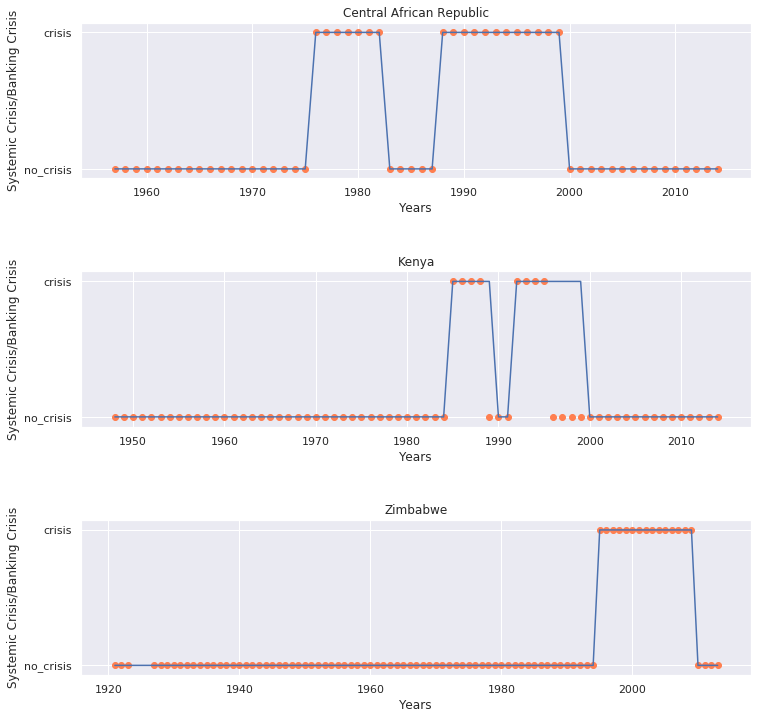

In [50]:
systemic = data[['year','country', 'systemic_crisis', 'exch_usd', 'banking_crisis']]
systemic = systemic[(systemic['country'] == 'Central African Republic') | (systemic['country']=='Kenya') | (systemic['country']=='Zimbabwe') ]
plt.figure(figsize=(12,12))
count = 1

for country in systemic.country.unique():
    plt.subplot(len(systemic.country.unique()),1,count)
    subset = systemic[(systemic['country'] == country)]
    sns.lineplot(subset['year'],subset['systemic_crisis'],ci=None)
    plt.scatter(subset['year'],subset["banking_crisis"], color='coral', label='Banking Crisis')
    plt.subplots_adjust(hspace=0.6)
    plt.xlabel('Years')
    plt.ylabel('Systemic Crisis/Banking Crisis')
    plt.title(country)
    count+=1

蓝色直线的取值代表系统性危机是否发生，红色散点代表银行危机是否发生，上图表明了危机是如何重叠的，从而证实了我们关于系统性危机对银行业危机有影响的假设。

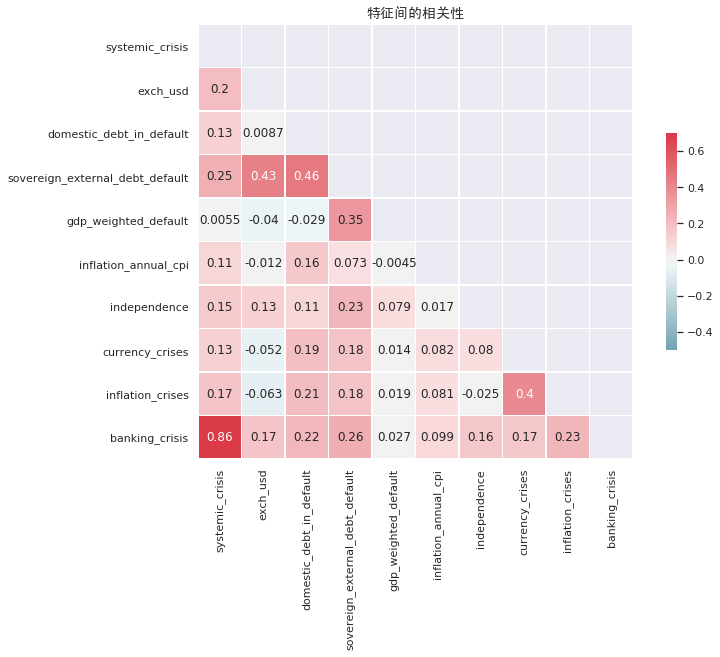

In [51]:
data['banking_crisis'] = data['banking_crisis'].map({"no_crisis":0,"crisis":1})

selected_features = ['systemic_crisis', 'exch_usd', 'domestic_debt_in_default','sovereign_external_debt_default', 'gdp_weighted_default',
       'inflation_annual_cpi', 'independence', 'currency_crises','inflation_crises','banking_crisis']

corr = data[selected_features].corr()

fig = plt.figure(figsize = (12,8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 绘制热力图
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-0.5,vmax=0.7, center=0,annot = True,
            square=True, linewidths=.5,cbar_kws={"shrink": .5});

plt.title("特征间的相关性",fontproperties = font)
plt.show()

除了看到系统性危机和银行危机的相关性极高之外，我们还了解到主权外债违约与货币兑美元的汇率相关性较大，接下来我们尝试构建一个分类模型，预测是否会发生银行危机。

# 3.构建银行危机预测模型

+ 特征编码
+ 数据集划分与分层采样
+ SMOTE合成采样
+ 建立随机森林预测模型
+ 模型效果的评估

## <a id=3.1></a> 3.1 特征编码

In [52]:
data.drop(['case','cc3'],axis = 1,inplace = True)
data = pd.get_dummies(data = data,columns = ['country'])
data.head()

year  systemic_crisis  exch_usd  domestic_debt_in_default  \
0  1870                1  0.052264                         0   
1  1871                0  0.052798                         0   
2  1872                0  0.052274                         0   
3  1873                0  0.051680                         0   
4  1874                0  0.051308                         0   

   sovereign_external_debt_default  gdp_weighted_default  \
0                                0                   0.0   
1                                0                   0.0   
2                                0                   0.0   
3                                0                   0.0   
4                                0                   0.0   

   inflation_annual_cpi  independence  currency_crises  inflation_crises  \
0              3.441456             0                0                 0   
1             14.149140             0                0                 0   
2             -3.718593             0                0                 0   
3             11.203897             0                0                 0   
4             -3.848561             0                0                 0   

         ...         country_Egypt  country_Ivory Coast  country_Kenya  \
0        ...                     0                    0              0   
1        ...                     0                    0              0   
2        ...                     0                    0              0   
3        ...                     0                    0              0   
4        ...                     0                    0              0   

   country_Mauritius  country_Morocco  country_Nigeria  country_South Africa  \
0                  0                0                0                     0   
1                  0                0                0                     0   
2                  0                0                0                     0   
3                  0                0                0                     0   
4                  0                0                0                     0   

   country_Tunisia  country_Zambia  country_Zimbabwe  
0                0               0                 0  
1                0               0                 0  
2                0               0                 0  
3                0               0                 0  
4                0               0                 0  

[5 rows x 24 columns]

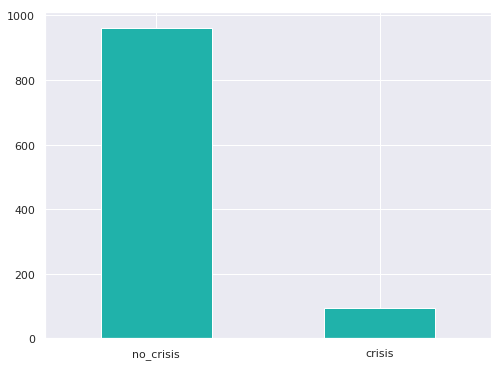

In [53]:
fig = plt.figure(figsize = (8,6))

data['banking_crisis'].value_counts().plot(kind='bar',rot = 360,color = 'lightseagreen')

plt.xticks([0,1],["no_crisis","crisis"])
plt.show()

可以看到，数据集中发生银行危机的情况远少于未发生银行危机的情况，比例约为10:1，对于此类不平衡数据，我们通常需要进行数据采样，同时为了更客观地构建预测模型和评估模型效果，应该尽量使得训练集和测试集中样本的比例相一致。需要使用分层采样的方法来划分训练集和测试集。

## <a id=3.2></a> 3.2 数据集划分与分层采样

下面我们开始对数据进行训练集与测试集的划分。在Sklearn中的`model_selection`模块，存在`train_test_split()`函数，用作训练集和测试集划分，函数语法为：`train_test_split(x,y,test_size = None,random_state = None,stratify = y)`，其中：

+ `x,y`: 分别为预测所需的所有特征，以及需要预测的特征。
+ `test_size`: 测试集比例，例如`test_size=0.2`则表示划分`20%`的数据作为测试集。
+ `random_state`: 随机种子，因为划分过程是随机的，为了进行可重复的训练，需要固定一个`random_state`，结果重现。
+ `stratif`y: 使用分层采样，保证从患病样本和未患病样本中抽取了同样比例的训练集和测试集。
函数最终将返回四个变量，分别为`x`的训练集和测试集，以及`y`的训练集和测试集。

In [54]:
from sklearn import model_selection

x = data.drop('banking_crisis',axis = 1)
y = data['banking_crisis']

x_train,x_test,y_train,y_test = model_selection.train_test_split(x, y,test_size=0.2,random_state = 33,stratify=y)


## <a id=3.3></a>  3.3 SMOTE合成采样

SMOTE算法的基本思想是对少数类样本进行分析并根据少数类样本人工合成新样本添加到数据集中。对于少数类样本a, 随机选择一个最近邻的样本b, 然后从a与b的连线上随机选取一个点c作为新的少数类样本。

在对数据集进行划分，接着对训练集进行过采样，将少数类进行扩充。在Python中使用imblearn.over_sampling的SMOTE类构建SMOTE过采样模型。

In [55]:
from imblearn.over_sampling import SMOTE
x_train_resampled, y_train_resampled = SMOTE(random_state=4).fit_sample(x_train, y_train)

print(x_train_resampled.shape, y_train_resampled.shape)

(1540, 23) (1540,)


## <a id=3.4></a> 3.4 建立随机森林预测模型

随机森林是一种集成学习方法，通过使用随机的方式从数据中抽取样本和特征，训练多个不同的决策树，形成“森林”。每个树都给出自己的分类意见，称“投票”。在分类问题下，森林选择选票最多的分类；在回归问题下则使用平均值。
在Python中使用`sklearn.ensemble`的`RandomForestClassifier`构建分类模型，其主要参数包括：

+ `n_estimators` : 训练分类器的数量(默认为100)；
+ `max_depth` : 每棵树的最大深度(默认为3)；
+ `max_features`: 划分的最大特征数(默认为 'auto')
+ `random_state` : 随机种子。

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, max_depth = 20,max_features = 10, random_state = 20)
rf.fit(x_train_resampled, y_train_resampled)
y_pred = rf.predict(x_test)

## <a id=3.5></a>  3.5 模型评估

在评价模型好坏时，我们分别使用函数`classification_report()`、`confusion_matrix()`和`accuracy_score()`,用于输出模型的预测报告、混淆矩阵和分类正确率。

混淆矩阵

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       192
          1       0.90      0.95      0.92        19

avg / total       0.99      0.99      0.99       211

[[190   2]
 [  1  18]]


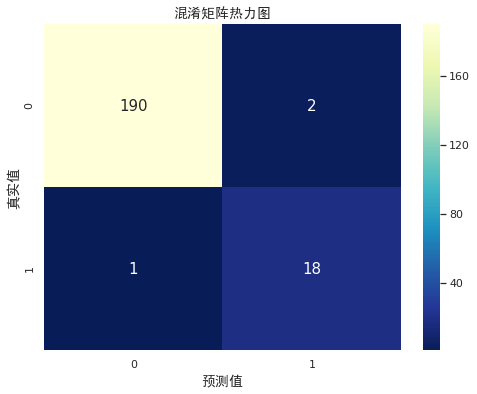

In [57]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, y_pred))
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix,ax=ax,annot=True,annot_kws={'size':15}, fmt='d',cmap = 'YlGnBu_r')
ax.set_ylabel('真实值',fontproperties = font)
ax.set_xlabel('预测值',fontproperties = font)
ax.set_title('混淆矩阵热力图',fontproperties = font)
plt.show()

通过混淆矩阵热力图可以看到，随机模型效果不错，对银行危机(少数类)的召回率达到了95%，接下来我们画出二分类的ROC_AUC曲线。

ROC曲线

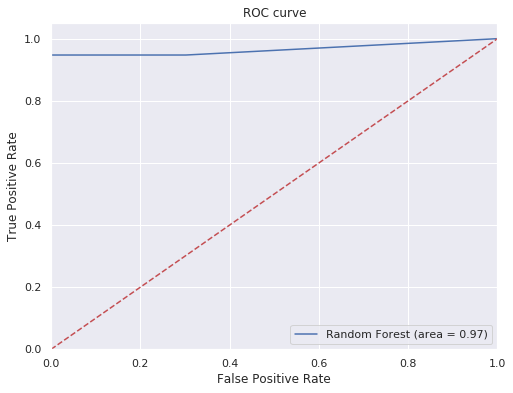

In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, rf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(x_test)[:,1])

plt.figure(figsize = (8,6))

plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

可以看到随机森林ROC曲线表现良好，接近左上角，AUC的值达到了0.97。最后，我们画出特征重要性排序图。

In [59]:
fig = plt.figure(figsize=(16,12))

rf_importance = rf.feature_importances_
index = data.drop(['banking_crisis'], axis=1).columns
rf_feature_importance = pd.DataFrame(rf_importance.T, index=index,columns=['score']).sort_values(by='score', ascending=True)

# 水平条形图绘制
rf_feature_importance.plot(kind='barh',legend=False,color = 'deepskyblue')

plt.title('随机森林特征重要性',fontproperties = font)

plt.show()

<Figure size 1152x864 with 0 Axes>

可以看到，系统危机`systemic_crisis`、年份`year`、年度cpi通货膨胀率`inflation_annual_cpi`和该国货币兑美元汇率`exch_used`重要性最高，这也进一步验证了我们在之前特征相关性分析的结论。

# 4.总结

本案例中我们首先通过统计指标对数据缺失和异常进行检测，并根据情况进行相应处理；接着通过探索各个国家货币对美元的汇率变化、通货膨胀率的变化以及国内国外债务违约情况等，通过可视化的方法对一些历史和经济现象进行了梳理。最后我们整理一系列特征，通过特征编码、SMOTE过采样等数据处理，并构建随机森林分类模型预测银行危机的发生。金融问题的预测一直是一个较为热门的话题，本案例的处理方法能够在一定程度上对金融数据的预测问题提供参考。